<a href="https://colab.research.google.com/github/victory256/Sample-ML-Repo/blob/hw08/%D0%AF%D0%BA%D1%83%D0%B1%D0%BE%D0%B2%D0%B0_hw08_best_home.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Предсказываем попупулярность объявления

0. <a href="#task">Задание</a>
1. <a href="#look_to_dataset">Посмотрим на имеющийся datasеt</a>
2. <a href="#add_features">Добавляем признаки</a>

   <a href="#chop_feature">--  Разбиваем признак feature</a>
3. <a href="#categorical_features">Заменяем категориальные признаки</a>
4. <a href="#choose_features">Выбираем признаки</a>
5. <a href="#fit_predict">Обучаем модель и предсказываем класс</a>


<a name="task"></a>
# Задание
В этом соревновании вам нужно предсказать популярность объявления о продаже домов в Нью-Йорке, основываясь на текстовом описании, локации, количестве спален, цене etc.

**Вы решаете задачу классификации: нужно предсказать TARGET − low, medium или high. Метрка − точность.**

train.csv − датасет для обучения (38 тысяч примеров, 12 признаков + лейбл)

test.csv − датасет для оценивания решений (11 тысяч примеров, 12 признаков)



1.   bathrooms: количество ванных
2.   bedrooms: количество спален
3.   building_id: ID здания
4.   created: дата создания объявления
5.   description
6.   display_address: адрес (текстом)
7.   features: список разных полезных текстовых тегов
8.   latitude: ширина (координата)
9.   listing_id: ID объявления
10.   longitude: долгода (координата)
11.   manager_id: ID риелтора
12.   photos: количество фотографий у объявления
13.   price: цена в долларах
14.   street_address

TARGET: целевая переменная: "low", "medium" или "high"












<a name="look_to_dataset"></a>
# 1. Посмотрим на имеющийся datasеt

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from collections import Counter
import plotly.graph_objs as go
import plotly.express as px
import copy

data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

In [2]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34546 entries, 0 to 34545
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               34546 non-null  int64  
 1   bathrooms        34546 non-null  float64
 2   bedrooms         34546 non-null  int64  
 3   building_id      34546 non-null  object 
 4   created          34546 non-null  object 
 5   description      33509 non-null  object 
 6   display_address  34458 non-null  object 
 7   features         34546 non-null  object 
 8   latitude         34546 non-null  float64
 9   listing_id       34546 non-null  int64  
 10  longitude        34546 non-null  float64
 11  manager_id       34546 non-null  object 
 12  photos           34546 non-null  object 
 13  price            34546 non-null  int64  
 14  street_address   34542 non-null  object 
 15  TARGET           34546 non-null  object 
dtypes: float64(3), int64(4), object(9)
memory usage: 4.2+ MB


У нас 34546 объявления и 15 признаков для каждого, `Target` наша целевая переменная.

Видим, что признаки description, display_address, street_address имеют пропущенные значения 1037 - 88 - 4 соответвенно

In [3]:
data_train.isna().sum()

Id                    0
bathrooms             0
bedrooms              0
building_id           0
created               0
description        1037
display_address      88
features              0
latitude              0
listing_id            0
longitude             0
manager_id            0
photos                0
price                 0
street_address        4
TARGET                0
dtype: int64

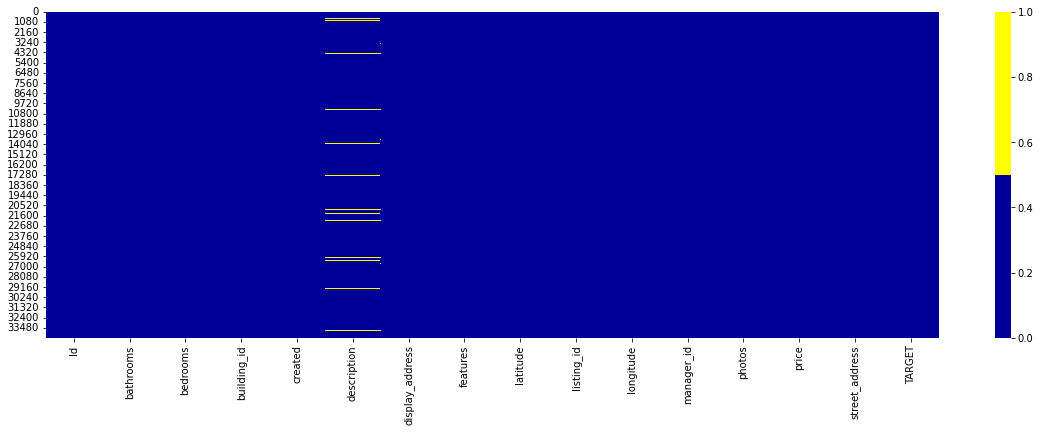

In [4]:
cols = data_train.columns
# определяем цвета 
# желтый - пропущенные данные, синий - не пропущенные
colours = ['#000099', '#ffff00'] 

plt.figure(figsize = (20,6))
sns.heatmap(data_train[cols].isnull(), cmap=sns.color_palette(colours))
None

Тепловая карта показывает, что значения пропущены в признаке description (1037 пропущенных). Для признаков display_address и street_address мало пропущенных ( 88 и 4), возможно поэтому мы их невидими на карте. Все три признака имеют тип object и по первым 5 строкам мы видим, что это текстовые описания. Возможно из description можно получить что-то полезное, но пока более интересным кажется признак features (список разных полезных текстовых тегов), который хорошо описывает каждое объявление.

Поэтому удалим из dataset эти три признака description, display_address, street_address

In [5]:
# Посмотрим на данные:
data_train.head()

,Id,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,TARGET
0,57094,1.0,3,0,2016-05-19 18:06:27,A FABULOUS 3BR IN MIDTOWN WEST! PERFECT APAR...,HOW AMAZING IS THIS MIDTOWN WEST STEAL!! NO FE...,"['Laundry In Unit', 'No Fee', 'Elevator']",40.7647,7039994,-73.9918,4bdc3d8c1aaa90d997ce2cb77680679b,['https://photos.renthop.com/2/7039994_07be01b...,4495,W 50 & AVE 10,medium
1,33389,1.0,1,9225efdfb57a50bf3ec17ebab082f94a,2016-06-16 02:01:49,Renovated Kitchen and Bathroom!,55 River Drive South,"['Dogs Allowed', 'Cats Allowed', 'No Fee']",40.7275,7166774,-74.0322,e5808a5e6cc13988fe596704428d38d5,['https://photos.renthop.com/2/7166774_03cf63a...,2570,55 River Drive South,medium
2,60458,1.0,0,320de7d3cc88e50a7fbbcfde1e825d21,2016-05-04 02:42:50,RARE AND BEST DEAL ON THE MARKET!!!! PERFECT S...,W 77 Street,"['Elevator', 'Hardwood Floors']",40.7798,6962716,-73.9751,d69d4e111612dd12ef864031c1148543,['https://photos.renthop.com/2/6962716_ec7f56f...,1795,22 W 77 Street,low
3,53048,1.0,2,ce6d18bf3238e668b2bf23f4110b7b67,2016-05-12 05:57:56,Newly renovated flex 2 apartment offers the ne...,John Street,"['Swimming Pool', 'Doorman', 'Elevator', 'Fitn...",40.7081,7002458,-74.0065,e6472c7237327dd3903b3d6f6a94515a,['https://photos.renthop.com/2/7002458_93f4010...,3400,100 John Street,low
4,592,1.0,3,fee4d465932160318364d9d48d272879,2016-06-16 06:06:15,LOW FEE apartments do not come around like thi...,West 16th Street,"['Laundry in Building', 'Laundry in Unit', 'Di...",40.7416,7170465,-74.0025,6fba9b3a8327c607b8b043716efee684,['https://photos.renthop.com/2/7170465_9c3f173...,5695,321 West 16th Street,low


In [6]:
data_train_1 = data_train.drop(columns=['description', 'display_address', 'street_address'])
data_train_1.head()

,Id,bathrooms,bedrooms,building_id,created,features,latitude,listing_id,longitude,manager_id,photos,price,TARGET
0,57094,1.0,3,0,2016-05-19 18:06:27,"['Laundry In Unit', 'No Fee', 'Elevator']",40.7647,7039994,-73.9918,4bdc3d8c1aaa90d997ce2cb77680679b,['https://photos.renthop.com/2/7039994_07be01b...,4495,medium
1,33389,1.0,1,9225efdfb57a50bf3ec17ebab082f94a,2016-06-16 02:01:49,"['Dogs Allowed', 'Cats Allowed', 'No Fee']",40.7275,7166774,-74.0322,e5808a5e6cc13988fe596704428d38d5,['https://photos.renthop.com/2/7166774_03cf63a...,2570,medium
2,60458,1.0,0,320de7d3cc88e50a7fbbcfde1e825d21,2016-05-04 02:42:50,"['Elevator', 'Hardwood Floors']",40.7798,6962716,-73.9751,d69d4e111612dd12ef864031c1148543,['https://photos.renthop.com/2/6962716_ec7f56f...,1795,low
3,53048,1.0,2,ce6d18bf3238e668b2bf23f4110b7b67,2016-05-12 05:57:56,"['Swimming Pool', 'Doorman', 'Elevator', 'Fitn...",40.7081,7002458,-74.0065,e6472c7237327dd3903b3d6f6a94515a,['https://photos.renthop.com/2/7002458_93f4010...,3400,low
4,592,1.0,3,fee4d465932160318364d9d48d272879,2016-06-16 06:06:15,"['Laundry in Building', 'Laundry in Unit', 'Di...",40.7416,7170465,-74.0025,6fba9b3a8327c607b8b043716efee684,['https://photos.renthop.com/2/7170465_9c3f173...,5695,low


Также параллельно удалим эти столбцы из test-данных, чтобы на момент обучения таблицы имели одинаковое количество столбцов.

In [7]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14806 entries, 0 to 14805
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               14806 non-null  object 
 1   bathrooms        14806 non-null  float64
 2   bedrooms         14806 non-null  int64  
 3   building_id      14806 non-null  object 
 4   created          14806 non-null  object 
 5   description      14397 non-null  object 
 6   display_address  14759 non-null  object 
 7   features         14806 non-null  object 
 8   latitude         14806 non-null  float64
 9   listing_id       14806 non-null  int64  
 10  longitude        14806 non-null  float64
 11  manager_id       14806 non-null  object 
 12  photos           14806 non-null  object 
 13  price            14806 non-null  int64  
 14  street_address   14800 non-null  object 
dtypes: float64(3), int64(3), object(9)
memory usage: 1.7+ MB


In [8]:
data_test_1 = data_test.drop(columns=['description', 'display_address', 'street_address'])
data_test_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14806 entries, 0 to 14805
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Id           14806 non-null  object 
 1   bathrooms    14806 non-null  float64
 2   bedrooms     14806 non-null  int64  
 3   building_id  14806 non-null  object 
 4   created      14806 non-null  object 
 5   features     14806 non-null  object 
 6   latitude     14806 non-null  float64
 7   listing_id   14806 non-null  int64  
 8   longitude    14806 non-null  float64
 9   manager_id   14806 non-null  object 
 10  photos       14806 non-null  object 
 11  price        14806 non-null  int64  
dtypes: float64(3), int64(3), object(6)
memory usage: 1.4+ MB


Возвращаемся к анализу train

In [9]:
data_train_1[data_train_1.duplicated() == True]

,Id,bathrooms,bedrooms,building_id,created,features,latitude,listing_id,longitude,manager_id,photos,price,TARGET


Дубликатов объявлений нет.

Пока не понятные поля building_id и manager_id. Посмотрим сколько у нас уникальных значений по этим принакам.

In [10]:
print('всего объектов = ',data_train_1.shape[0])
print('кол-во уникальных значений building_id = ',len(data_train_1['building_id'].unique()))
print('кол-во уникальных значений manager_id = ',len(data_train_1['manager_id'].unique()))

всего объектов =  34546
кол-во уникальных значений building_id =  6378
кол-во уникальных значений manager_id =  3134


Значит из 34,5 тысяч объявлений домов на самом деле продаются только  building_id (ID здания) = 6378 домов? Это надо проверить.

И всего в нашей базе работают manager_id (ID риелтора) = 3134 риелтора. Это звучит реалистично.

Для ответа на предыдущий вопрос возьмем из нашего dataset данные по одному дому, например, по четвертому.

In [11]:
data_train_1_oneHouse = data_train_1[data_train_1['building_id'] == data_train_1['building_id'][3]]
print('кол-во объявлений для дома ',data_train_1['building_id'][3],' = ',data_train_1_oneHouse.shape[0])
data_train_1_oneHouse.head()

кол-во объявлений для дома  ce6d18bf3238e668b2bf23f4110b7b67  =  119


,Id,bathrooms,bedrooms,building_id,created,features,latitude,listing_id,longitude,manager_id,photos,price,TARGET
3,53048,1.0,2,ce6d18bf3238e668b2bf23f4110b7b67,2016-05-12 05:57:56,"['Swimming Pool', 'Doorman', 'Elevator', 'Fitn...",40.7081,7002458,-74.0065,e6472c7237327dd3903b3d6f6a94515a,['https://photos.renthop.com/2/7002458_93f4010...,3400,low
302,97500,1.0,4,ce6d18bf3238e668b2bf23f4110b7b67,2016-04-28 02:20:48,"['Swimming Pool', 'Doorman', 'Elevator', 'Fitn...",40.7081,6935348,-74.0065,1baa1601362296b57892febc35f6b07b,['https://photos.renthop.com/2/6935348_1591a36...,4700,high
455,113642,1.0,3,ce6d18bf3238e668b2bf23f4110b7b67,2016-04-13 05:25:23,"['Roof Deck', 'Doorman', 'Elevator', 'Fitness ...",40.7081,6866935,-74.0065,ba82cb585bc2be6819241b2d1c900b88,['https://photos.renthop.com/2/6866935_dd71383...,3950,medium
813,77534,1.0,1,ce6d18bf3238e668b2bf23f4110b7b67,2016-05-03 06:23:35,"['Roof Deck', 'Doorman', 'Elevator', 'Fitness ...",40.7081,6960041,-74.0065,fef690cb34be367eddfe2490805ba621,['https://photos.renthop.com/2/6960041_df0e0bf...,3350,low
891,93301,1.0,2,ce6d18bf3238e668b2bf23f4110b7b67,2016-04-05 06:32:58,"['Roof Deck', 'Doorman', 'Elevator', 'Fitness ...",40.7081,6826741,-74.0065,614e9c02bcb1b7feaff502d4c1203c47,['https://photos.renthop.com/2/6826741_388193e...,2725,medium


У выбранных объявлений совпадают географические координаты, значит действительно для одного дома несколько объявлений. Наша задача "предсказать популярность объявления о продаже домов в Нью-Йорке". Для 4 дома у нас получилось 119 объявлений. В описании features указано Roof Deck, Looft, Elevator. Значит мы смотрим обявления не о продаже домов, а о продаже квартир.

Интересно в каких пределах изменяется latitude (широта-координата) и longitude (долгода-координата). Нанесем наши точки на карту.

Нью-Йорк находится примерно на 40° северной широты и 74° западной долготы.

In [12]:
fig = go.Figure(go.Scattermapbox(lat=data_train_1['latitude'], lon=data_train_1['longitude']))
fig.update_layout(mapbox_style="open-street-map")
fig.show()

Видим, что есть точка с координатами (0,0) - удалим ее, она нам не поможет, т.к. очень далеко от Нью-Йорка и больше похожа на выброс.

In [13]:
data_train_1[data_train_1['latitude']==0].shape[0]

8

Получилось 8 точек с координатами (0,0) 

In [14]:
data_train_1 = data_train_1.drop(np.where(data_train_1['latitude'] == 0)[0])
data_train_1[data_train_1['latitude']==0].shape[0]

0

Удалили точки с координатами (0,0). Теперь еще раз построим карту. И сдвинем центр карты, чтобы им стал Нью-Йорк

In [15]:
fig = go.Figure(go.Scattermapbox(lat=data_train_1['latitude'], lon=data_train_1['longitude']))
map_center =dict(lat=42, lon=-74)
fig.update_layout(mapbox_style="open-street-map", mapbox=dict(center=map_center, zoom=5))
fig.show()

Теперь мы хорошо видим город. Только есть еще лишние точки: к нам попали объявления из Бостона и есть даже недолеко от Оттавы. Их тоже надо убрать, потому что на вопрос нашей задачи "предсказать популярность объявления о продаже домов в Нью-Йорке" они не ответят.

In [16]:
data_train_1=data_train_1[data_train_1['latitude'] < 42]
data_train_1=data_train_1[data_train_1['latitude'] > 40.2]
data_train_1=data_train_1[data_train_1['longitude'] < -73.3]
fig = go.Figure(go.Scattermapbox(lat=data_train_1['latitude'], lon=data_train_1['longitude']))
map_center =dict(lat=40.8, lon=-74)
fig.update_layout(mapbox_style="open-street-map", mapbox=dict(center=map_center, zoom=8))
fig.show()

<a name="add_features"></a>
# 2. Добавляем признаки

1.   У нас есть хороший признак features(список разных полезных текстовых тегов). Надо посмотреть какие теги есть в нашем dataset и добавить их как дополнительные признаки. 
2.   Признак photos (количество фотографий у объявления) содержит список ссылок на фотографии. Нам этом список не поможет, а вот количество фотографий пригодится. Поэтому можно добавить признак количество фотографий.
3.   Разделим признак created на дату и время. Пока не знаю поможет это или нет. Потом надо посмотреть есть ли зависимость target от даты.
4.   Подсказка от учителя. Лучше вместо стоймости квартиры рассматривать стоймость одной комнаты. Линейная модель сама такой признак не сгенерирует, т.к. здесь обратно пропорциональная зависимость


In [17]:
feat_all=set()
for i in data_train_1['features'].index:
  features_str=data_train_1['features'][i]
  if len(features_str)>2:         # чтобы не обрабатывать features=[]
    features_str = features_str[2:-2]
    if features_str.find(' * ')>0:
      feat=features_str.split(" * ")
    else:
      feat=features_str.split("', '")
    feat_all.update(set(feat))    # в feat_all лежат все полезные теги из features
print('кол-во полезных тегов из feature=',len(feat_all))
#feat_all

кол-во полезных тегов из feature= 1425


Что-то много полезных тегов получилось. Надо подумать какие из них можно добавить, все думаю точно не надо. Например, добавить признак "можно или нет с животными", "наличие спорт зала".

Сначало добавим столбцы: кол-во фотографий, дата, время, стоймость одной комнаты. А потом подумаем про теги.

In [18]:
data_train_1.head()

,Id,bathrooms,bedrooms,building_id,created,features,latitude,listing_id,longitude,manager_id,photos,price,TARGET
0,57094,1.0,3,0,2016-05-19 18:06:27,"['Laundry In Unit', 'No Fee', 'Elevator']",40.7647,7039994,-73.9918,4bdc3d8c1aaa90d997ce2cb77680679b,['https://photos.renthop.com/2/7039994_07be01b...,4495,medium
1,33389,1.0,1,9225efdfb57a50bf3ec17ebab082f94a,2016-06-16 02:01:49,"['Dogs Allowed', 'Cats Allowed', 'No Fee']",40.7275,7166774,-74.0322,e5808a5e6cc13988fe596704428d38d5,['https://photos.renthop.com/2/7166774_03cf63a...,2570,medium
2,60458,1.0,0,320de7d3cc88e50a7fbbcfde1e825d21,2016-05-04 02:42:50,"['Elevator', 'Hardwood Floors']",40.7798,6962716,-73.9751,d69d4e111612dd12ef864031c1148543,['https://photos.renthop.com/2/6962716_ec7f56f...,1795,low
3,53048,1.0,2,ce6d18bf3238e668b2bf23f4110b7b67,2016-05-12 05:57:56,"['Swimming Pool', 'Doorman', 'Elevator', 'Fitn...",40.7081,7002458,-74.0065,e6472c7237327dd3903b3d6f6a94515a,['https://photos.renthop.com/2/7002458_93f4010...,3400,low
4,592,1.0,3,fee4d465932160318364d9d48d272879,2016-06-16 06:06:15,"['Laundry in Building', 'Laundry in Unit', 'Di...",40.7416,7170465,-74.0025,6fba9b3a8327c607b8b043716efee684,['https://photos.renthop.com/2/7170465_9c3f173...,5695,low


In [19]:
data_train_1.describe()

,Id,bathrooms,bedrooms,latitude,listing_id,longitude,price
count,34524.000000,34524.000000,34524.000000,34524.000000,3.452400e+04,34524.000000,3.452400e+04
mean,61875.062044,1.210839,1.540580,40.750813,7.024896e+06,-73.972598,3.887370e+03
std,35717.698796,0.495111,1.116328,0.039656,1.263573e+05,0.030475,2.631425e+04
min,6.000000,0.000000,0.000000,40.506500,6.811965e+06,-74.663700,4.500000e+01
25%,30839.750000,1.000000,1.000000,40.728000,6.917209e+06,-73.991700,2.500000e+03
50%,61818.000000,1.000000,1.000000,40.751600,7.021807e+06,-73.977900,3.150000e+03
75%,92711.500000,1.000000,2.000000,40.774000,7.130020e+06,-73.955000,4.100000e+03
max,124009.000000,6.000000,8.000000,41.086800,7.742803e+06,-73.540000,4.490000e+06


In [20]:
(data_train_1['bedrooms']+data_train_1['bathrooms']).value_counts()

2.0     10740
3.0      7773
1.0      6571
4.0      4848
5.0      2219
6.0      1138
4.5       211
7.0       210
3.5       160
5.5       155
2.5       116
0.0       105
8.0        87
6.5        61
9.0        54
7.5        26
8.5        17
10.0       13
1.5         8
9.5         6
11.0        3
10.5        2
12.0        1
dtype: int64

При расчете стоймости одной комнаты = price / (bathrooms + bedrooms) появилось деление на 0, т.к. в некоторых объявлениях не указано количество комнат. Всего получилось 105 объявлений, где не указано ни количество спален ни количество ванных комнат. Думаю, что хотя бы одна комната должна быть в квартире, поэтому ставлю 1 комнату для расчета, если комнаты в сумме = 0.

Пока не будем удалять признаки. В пункте про обучения сравним результаты на разном количестве признаков.

In [21]:
def count_photo(photo_str):  # считаем кол-во фотографий в поле photos
  photo_str = photo_str[2:-2]
  return len(photo_str.split("', '"))

In [22]:
data_train_2 = data_train_1.copy(deep=True)

data_train_2['photos']= data_train_2['photos'].apply(count_photo)   # кол-во фотографий = заменили признак
data_train_2['price_one_room']=round(data_train_2['price'] / np.maximum(1,data_train_2['bathrooms'] +
                                                              data_train_2['bedrooms']),2)      # стоймость одной комнаты = новый признак

data_train_2['created']=pd.to_datetime(data_train_2['created'])

#data_train_2['date']=pd.to_datetime(data_train_2['created']).dt.date      # дата создания объявления = новый признак
#data_train_2['time']=pd.to_datetime(data_train_2['created']).dt.time      # время создания объявления = новый признак
data_train_2['day']=pd.to_datetime(data_train_2['created']).dt.day        # день создания объявления = новый признак
data_train_2['month']=pd.to_datetime(data_train_2['created']).dt.month    # месяц создания объявления = новый признак
data_train_2['year']=pd.to_datetime(data_train_2['created']).dt.year      # год создания объявления = новый признак

#data_train_2 = data_train_2.drop(columns=['created'])     # разбили признак на части, поэтому удалили
#data_train_2 = data_train_2.drop(columns=['bedrooms','bathrooms','price'])     # заменили одним price_one_room признаком, поэтому удалили

data_train_2.head(5)


,Id,bathrooms,bedrooms,building_id,created,features,latitude,listing_id,longitude,manager_id,photos,price,TARGET,price_one_room,day,month,year
0,57094,1.0,3,0,2016-05-19 18:06:27,"['Laundry In Unit', 'No Fee', 'Elevator']",40.7647,7039994,-73.9918,4bdc3d8c1aaa90d997ce2cb77680679b,3,4495,medium,1123.75,19,5,2016
1,33389,1.0,1,9225efdfb57a50bf3ec17ebab082f94a,2016-06-16 02:01:49,"['Dogs Allowed', 'Cats Allowed', 'No Fee']",40.7275,7166774,-74.0322,e5808a5e6cc13988fe596704428d38d5,13,2570,medium,1285.00,16,6,2016
2,60458,1.0,0,320de7d3cc88e50a7fbbcfde1e825d21,2016-05-04 02:42:50,"['Elevator', 'Hardwood Floors']",40.7798,6962716,-73.9751,d69d4e111612dd12ef864031c1148543,6,1795,low,1795.00,4,5,2016
3,53048,1.0,2,ce6d18bf3238e668b2bf23f4110b7b67,2016-05-12 05:57:56,"['Swimming Pool', 'Doorman', 'Elevator', 'Fitn...",40.7081,7002458,-74.0065,e6472c7237327dd3903b3d6f6a94515a,4,3400,low,1133.33,12,5,2016
4,592,1.0,3,fee4d465932160318364d9d48d272879,2016-06-16 06:06:15,"['Laundry in Building', 'Laundry in Unit', 'Di...",40.7416,7170465,-74.0025,6fba9b3a8327c607b8b043716efee684,3,5695,low,1423.75,16,6,2016


In [23]:
data_train_2.describe()

,Id,bathrooms,bedrooms,latitude,listing_id,longitude,photos,price,price_one_room,day,month,year
count,34524.000000,34524.000000,34524.000000,34524.000000,3.452400e+04,34524.000000,34524.00000,3.452400e+04,3.452400e+04,34524.000000,34524.000000,34524.0
mean,61875.062044,1.210839,1.540580,40.750813,7.024896e+06,-73.972598,5.67889,3.887370e+03,1.599978e+03,15.213822,5.019841,2016.0
std,35717.698796,0.495111,1.116328,0.039656,1.263573e+05,0.030475,3.50534,2.631425e+04,9.281989e+03,8.260530,0.823457,0.0
min,6.000000,0.000000,0.000000,40.506500,6.811965e+06,-74.663700,1.00000,4.500000e+01,4.500000e+01,1.000000,4.000000,2016.0
25%,30839.750000,1.000000,1.000000,40.728000,6.917209e+06,-73.991700,4.00000,2.500000e+03,1.000000e+03,8.000000,4.000000,2016.0
50%,61818.000000,1.000000,1.000000,40.751600,7.021807e+06,-73.977900,5.00000,3.150000e+03,1.310000e+03,15.000000,5.000000,2016.0
75%,92711.500000,1.000000,2.000000,40.774000,7.130020e+06,-73.955000,7.00000,4.100000e+03,1.875000e+03,22.000000,6.000000,2016.0
max,124009.000000,6.000000,8.000000,41.086800,7.742803e+06,-73.540000,50.00000,4.490000e+06,1.496667e+06,31.000000,6.000000,2016.0


Добавим в test аналогичные признаки

In [24]:
data_test_2 = data_test_1.copy(deep=True)

data_test_2['photos']= data_test_2['photos'].apply(count_photo)   # кол-во фотографий = заменили признак
data_test_2['price_one_room']=round(data_test_2['price'] / np.maximum(1,data_test_2['bathrooms'] +
                                                              data_test_2['bedrooms']),2)      # стоймость одной комнаты = новый признак

data_test_2['created']=pd.to_datetime(data_train_2['created'])

data_test_2['day']=pd.to_datetime(data_test_2['created']).dt.day        # день создания объявления = новый признак
data_test_2['month']=pd.to_datetime(data_test_2['created']).dt.month    # месяц создания объявления = новый признак
data_test_2['year']=pd.to_datetime(data_test_2['created']).dt.year      # год создания объявления = новый признак

#data_test_2.head(5)

In [25]:
data_train_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34524 entries, 0 to 34545
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Id              34524 non-null  int64         
 1   bathrooms       34524 non-null  float64       
 2   bedrooms        34524 non-null  int64         
 3   building_id     34524 non-null  object        
 4   created         34524 non-null  datetime64[ns]
 5   features        34524 non-null  object        
 6   latitude        34524 non-null  float64       
 7   listing_id      34524 non-null  int64         
 8   longitude       34524 non-null  float64       
 9   manager_id      34524 non-null  object        
 10  photos          34524 non-null  int64         
 11  price           34524 non-null  int64         
 12  TARGET          34524 non-null  object        
 13  price_one_room  34524 non-null  float64       
 14  day             34524 non-null  int64         
 15  mo

Вернемся к анализу train-объявлений

Посмотрим как можно сгруппировать полезные теги

<a name="chop_feature"></a>
## Разбиваем признак feature

In [26]:
# доступ к крыше
for i in feat_all:
  i=i.lower()
  if i.find('roof')>=0 and i.find('proof')<0:
    None #print(i)

In [27]:
# без комиссия риелтору или низкая комиссия
for i in feat_all:
  i=i.lower()
  if i.find('fee')>=0 and i.find('additional fee')<0:
    None #print(i)

In [28]:
# наличие лифта
for i in feat_all:
  i=i.lower()
  if i.find('elevator')>=0: 
    None #print(i)

In [29]:
# наличие шкафа или место для хранения
for i in feat_all:
  i=i.lower()
  if i.find('closet')>=0 or i.find('storage')>=0:
    None #print(i)

In [30]:
# разрешено с животными
for i in feat_all:
  i=i.lower()
  if (i.find('pets')>=0 and i.find('no pets')<0) or i.find('cats')>=0 or i.find('dogs')>=0 or i.find('animal')>=0:
    None #print(i)

In [31]:
# наличие спорт зал
for i in feat_all:
  i=i.lower()
  if i.find('fitness')>=0 or i.find('gym')>=0 or i.find('pool')>=0 or i.find('court')>=0  or i.find('basketball')>=0  or i.find('yoga')>=0  or i.find('pilates')>=0:
    None #print(i)

In [32]:
# наличие прачечной
for i in feat_all:
  i=i.lower()
  if i.find('laundry')>=0: 
    None #print(i)

In [33]:
# наличие парковки
for i in feat_all:
  i=i.lower()
  if i.find('garage')>=0 or i.find('parking')>=0: 
    None #print(i)

In [34]:
# наличие кухни
for i in feat_all:
  i=i.lower()
  if i.find('kitchen')>=0: 
    None #print(i)

In [35]:
# наличие какой-либо техники - TV, кондиционер, микроволновка, стиральная и сушильная машина, посудомоечная машина, камин
for i in feat_all:
  i=i.lower()
  if i.find('tv')>=0 or i.find('condition')>=0 or i.find('microwave')>=0 or i.find('dryer')>=0 or i.find('washer')>=0 or i.find('dishwasher')>=0 or i.find('fireplace')>=0: 
    None #print(i)

In [36]:
# естественый свет
for i in feat_all:
  i=i.lower()
  if i.find('light')>=0 or i.find('window')>=0: 
    None #print(i)

In [37]:
# оплата за газ, воду, электричество, отопление
for i in feat_all:
  i=i.lower()
  if i.find('water')>=0 or i.find('gas')>=0 or i.find('heat')>=0: 
    None #print(i)

In [38]:
# наличие детской комнаты
for i in feat_all:
  i=i.lower()
  if i.find('playroom')>=0: 
    None #print(i)

In [39]:
# наличие деревянного пола
for i in feat_all:
  i=i.lower()
  if (i.find('wood')>=0 or i.find('oak')>=0 or i.find('parquet')>=0 ) and i.find('soaking')<0: 
    None #print(i)

In [40]:
# хороший вид
for i in feat_all:
  i=i.lower()
  if i.find('view')>=0: 
    None #print(i)

In [41]:
# наличие сада, дворика, террасы, балкона, парка
for i in feat_all:
  i=i.lower()
  if i.find('yard')>=0 or i.find('garden')>=0 or i.find('terrace')>=0 or i.find('balcony')>=0 or (i.find('park')>=0 and i.find('parking')<0): 
    None #print(i)

In [42]:
# наличие интернета, blutooth, wifi 
for i in feat_all:
  i=i.lower()
  if i.find('internet')>=0 or i.find('wifi')>=0 or i.find('wi-fi')>=0 or i.find('blutooth')>=0: 
    None #print(i)

In [43]:
# наличие консьержа, швейцара, домофона 
for i in feat_all:
  i=i.lower()
  if i.find('concierge')>=0 or i.find('doorman')>=0 or i.find('intercom')>=0: 
    None #print(i)

In [44]:
# 1) доступ к крыше
def feat_roof(features_str):   
  features_str=features_str.lower()
  if features_str.find('roof')>=0 and features_str.find('proof')<0:
    return 1
  else:
    return 0
# 2) без комиссия риелтору или низкая комиссия
def feat_fee(features_str):   
  features_str=features_str.lower()
  if features_str.find('fee')>=0 and features_str.find('additional fee')<0:
    return 1
  else:
    return 0
# 3) наличие лифта
def feat_elevator(features_str):   
  features_str=features_str.lower()
  if features_str.find('elevator')>=0:
    return 1
  else:
    return 0
# 4) наличие шкафа или место для хранения
def feat_storage(features_str):   
  features_str=features_str.lower()
  if features_str.find('closet')>=0 or features_str.find('storage')>=0:
    return 1
  else:
    return 0
# 5) разрешено с животными
def feat_pets(features_str):   
  features_str=features_str.lower()
  if (features_str.find('pets')>=0 and features_str.find('no pets')<0) or \
  features_str.find('cats')>=0 or features_str.find('dogs')>=0 or features_str.find('animal')>=0:
    return 1
  else:
    return 0
# 6) наличие спорт зал
def feat_fitness(features_str):   
  features_str=features_str.lower()
  if features_str.find('fitness')>=0 or features_str.find('gym')>=0 or \
  features_str.find('pool')>=0 or features_str.find('court')>=0  or \
  features_str.find('basketball')>=0  or features_str.find('yoga')>=0  or \
  features_str.find('pilates')>=0:
    return 1
  else:
    return 0
# 7) наличие прачечной
def feat_laundry(features_str):   
  features_str=features_str.lower()
  if features_str.find('laundry')>=0:
    return 1
  else:
    return 0
# 8) наличие парковки
def feat_garage(features_str):   
  features_str=features_str.lower()
  if features_str.find('garage')>=0 or features_str.find('parking')>=0: 
    return 1
  else:
    return 0
# 9) наличие кухни
def feat_kitchen(features_str):   
  features_str=features_str.lower()
  if features_str.find('kitchen')>=0:
    return 1
  else:
    return 0
# 10) наличие какой-либо техники - TV, кондиционер, микроволновка, стиральная и сушильная машина, посудомоечная машина, камин
def feat_tech(features_str):   
  features_str=features_str.lower()
  if features_str.find('tv')>=0 or features_str.find('condition')>=0 or \
   features_str.find('microwave')>=0 or features_str.find('dryer')>=0 or \
   features_str.find('washer')>=0 or features_str.find('dishwasher')>=0 or \
   features_str.find('fireplace')>=0: 
    return 1
  else:
    return 0
# 11) естественый свет
def feat_light(features_str):   
  features_str=features_str.lower()
  if features_str.find('light')>=0 or features_str.find('window')>=0:
    return 1
  else:
    return 0
# 12) оплата за газ, воду, электричество, отопление
def feat_wgh(features_str):   
  features_str=features_str.lower()
  if features_str.find('water')>=0 or features_str.find('gas')>=0 or features_str.find('heat')>=0: 
    return 1
  else:
    return 0
# 13) наличие детской комнаты
def feat_playroom(features_str):   
  features_str=features_str.lower()
  if features_str.find('playroom')>=0:
    return 1
  else:
    return 0
# 14) наличие деревянного пола
def feat_wood(features_str):   
  features_str=features_str.lower()
  if (features_str.find('wood')>=0 or features_str.find('oak')>=0 or \
      features_str.find('parquet')>=0 ) and features_str.find('soaking')<0: 
    return 1
  else:
    return 0
# 15) хороший вид
def feat_view(features_str):   
  features_str=features_str.lower()
  if features_str.find('view')>=0:
    return 1
  else:
    return 0
# 16) наличие сада, дворика, террасы, балкона, парка
def feat_laundry(features_str):   
  features_str=features_str.lower()
  if features_str.find('yard')>=0 or features_str.find('garden')>=0 or \
  features_str.find('terrace')>=0 or features_str.find('balcony')>=0 or \
  (features_str.find('park')>=0 and features_str.find('parking')<0): 
    return 1
  else:
    return 0                    
# 17) наличие интернета, blutooth, wifi 
def feat_wifi(features_str):   
  features_str=features_str.lower()
  if features_str.find('internet')>=0 or features_str.find('wifi')>=0 or \
  features_str.find('wi-fi')>=0 or features_str.find('blutooth')>=0: 
    return 1
  else:
    return 0
# 18) наличие консьержа, швейцара, домофона 
def feat_concierge(features_str):   
  features_str=features_str.lower()
  if features_str.find('concierge')>=0 or features_str.find('doorman')>=0 or \
  features_str.find('intercom')>=0: 
    return 1
  else:
    return 0

Каждую из найденных характеристик добавим бинарным признаком. Есть в списке тэгов объявления характеристика = 1, нет = 0.

In [45]:
data_train_2['feat_roof']= data_train_2['features'].apply(feat_roof)   # 1) доступ к крыше = добавили признак
data_train_2['feat_fee']= data_train_2['features'].apply(feat_fee)   # 2) без комиссия риелтору или низкая комиссия = добавили признак
data_train_2['feat_elevator']= data_train_2['features'].apply(feat_elevator)   # 3) наличие лифта = добавили признак
data_train_2['feat_storage']= data_train_2['features'].apply(feat_storage)   # 4) наличие шкафа или место для хранения = добавили признак
data_train_2['feat_pets']= data_train_2['features'].apply(feat_pets)   # 5) разрешено с животными = добавили признак
data_train_2['feat_fitness']= data_train_2['features'].apply(feat_fitness)   # 6) наличие спорт зал = добавили признак
data_train_2['feat_laundry']= data_train_2['features'].apply(feat_laundry)   # 7) наличие прачечной = добавили признак
data_train_2['feat_garage']= data_train_2['features'].apply(feat_garage)   # 8) наличие парковки = добавили признак
data_train_2['feat_kitchen']= data_train_2['features'].apply(feat_kitchen)   # 9) наличие кухни = добавили признак
data_train_2['feat_tech']= data_train_2['features'].apply(feat_tech)   # 10) наличие какой-либо техники = добавили признак
data_train_2['feat_light']= data_train_2['features'].apply(feat_light)   # 11) естественый свет = добавили признак
data_train_2['feat_wgh']= data_train_2['features'].apply(feat_wgh)   # 12) оплата за газ, воду, электричество, отопление = добавили признак
data_train_2['feat_playroom']= data_train_2['features'].apply(feat_playroom)   # 13) наличие детской комнаты = добавили признак
data_train_2['feat_wood']= data_train_2['features'].apply(feat_wood)   # 14) наличие деревянного пола = добавили признак
data_train_2['feat_view']= data_train_2['features'].apply(feat_view)   # 15) хороший вид = добавили признак
data_train_2['feat_laundry']= data_train_2['features'].apply(feat_laundry)   # 16) наличие сада, дворика, террасы, балкона, парка = добавили признак
data_train_2['feat_wifi']= data_train_2['features'].apply(feat_wifi)   # 17) наличие интернета, blutooth, wifi = добавили признак
data_train_2['feat_concierge']= data_train_2['features'].apply(feat_concierge)   # 18) наличие консьержа, швейцара, домофона = добавили признак
#data_train_2 = data_train_2.drop(columns=['features'])  # разбили признак на части, поэтому удалили
data_train_2.head(5)

,Id,bathrooms,bedrooms,building_id,created,features,latitude,listing_id,longitude,manager_id,...,feat_garage,feat_kitchen,feat_tech,feat_light,feat_wgh,feat_playroom,feat_wood,feat_view,feat_wifi,feat_concierge
0,57094,1.0,3,0,2016-05-19 18:06:27,"['Laundry In Unit', 'No Fee', 'Elevator']",40.7647,7039994,-73.9918,4bdc3d8c1aaa90d997ce2cb77680679b,...,0,0,0,0,0,0,0,0,0,0
1,33389,1.0,1,9225efdfb57a50bf3ec17ebab082f94a,2016-06-16 02:01:49,"['Dogs Allowed', 'Cats Allowed', 'No Fee']",40.7275,7166774,-74.0322,e5808a5e6cc13988fe596704428d38d5,...,0,0,0,0,0,0,0,0,0,0
2,60458,1.0,0,320de7d3cc88e50a7fbbcfde1e825d21,2016-05-04 02:42:50,"['Elevator', 'Hardwood Floors']",40.7798,6962716,-73.9751,d69d4e111612dd12ef864031c1148543,...,0,0,0,0,0,0,1,0,0,0
3,53048,1.0,2,ce6d18bf3238e668b2bf23f4110b7b67,2016-05-12 05:57:56,"['Swimming Pool', 'Doorman', 'Elevator', 'Fitn...",40.7081,7002458,-74.0065,e6472c7237327dd3903b3d6f6a94515a,...,0,0,1,0,0,0,1,0,0,1
4,592,1.0,3,fee4d465932160318364d9d48d272879,2016-06-16 06:06:15,"['Laundry in Building', 'Laundry in Unit', 'Di...",40.7416,7170465,-74.0025,6fba9b3a8327c607b8b043716efee684,...,0,0,1,0,0,0,1,0,0,0


Добавим в test аналогичные признаки из features

In [46]:
data_test_2['feat_roof']= data_test_2['features'].apply(feat_roof)   # 1) доступ к крыше = добавили признак
data_test_2['feat_fee']= data_test_2['features'].apply(feat_fee)   # 2) без комиссия риелтору или низкая комиссия = добавили признак
data_test_2['feat_elevator']= data_test_2['features'].apply(feat_elevator)   # 3) наличие лифта = добавили признак
data_test_2['feat_storage']= data_test_2['features'].apply(feat_storage)   # 4) наличие шкафа или место для хранения = добавили признак
data_test_2['feat_pets']= data_test_2['features'].apply(feat_pets)   # 5) разрешено с животными = добавили признак
data_test_2['feat_fitness']= data_test_2['features'].apply(feat_fitness)   # 6) наличие спорт зал = добавили признак
data_test_2['feat_laundry']= data_test_2['features'].apply(feat_laundry)   # 7) наличие прачечной = добавили признак
data_test_2['feat_garage']= data_test_2['features'].apply(feat_garage)   # 8) наличие парковки = добавили признак
data_test_2['feat_kitchen']= data_test_2['features'].apply(feat_kitchen)   # 9) наличие кухни = добавили признак
data_test_2['feat_tech']= data_test_2['features'].apply(feat_tech)   # 10) наличие какой-либо техники = добавили признак
data_test_2['feat_light']= data_test_2['features'].apply(feat_light)   # 11) естественый свет = добавили признак
data_test_2['feat_wgh']= data_test_2['features'].apply(feat_wgh)   # 12) оплата за газ, воду, электричество, отопление = добавили признак
data_test_2['feat_playroom']= data_test_2['features'].apply(feat_playroom)   # 13) наличие детской комнаты = добавили признак
data_test_2['feat_wood']= data_test_2['features'].apply(feat_wood)   # 14) наличие деревянного пола = добавили признак
data_test_2['feat_view']= data_test_2['features'].apply(feat_view)   # 15) хороший вид = добавили признак
data_test_2['feat_laundry']= data_test_2['features'].apply(feat_laundry)   # 16) наличие сада, дворика, террасы, балкона, парка = добавили признак
data_test_2['feat_wifi']= data_test_2['features'].apply(feat_wifi)   # 17) наличие интернета, blutooth, wifi = добавили признак
data_test_2['feat_concierge']= data_test_2['features'].apply(feat_concierge)   # 18) наличие консьержа, швейцара, домофона = добавили признак
data_test_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14806 entries, 0 to 14805
Data columns (total 33 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Id              14806 non-null  object        
 1   bathrooms       14806 non-null  float64       
 2   bedrooms        14806 non-null  int64         
 3   building_id     14806 non-null  object        
 4   created         14795 non-null  datetime64[ns]
 5   features        14806 non-null  object        
 6   latitude        14806 non-null  float64       
 7   listing_id      14806 non-null  int64         
 8   longitude       14806 non-null  float64       
 9   manager_id      14806 non-null  object        
 10  photos          14806 non-null  int64         
 11  price           14806 non-null  int64         
 12  price_one_room  14806 non-null  float64       
 13  day             14795 non-null  float64       
 14  month           14795 non-null  float64       
 15  ye

<a name="categorical_features"></a>
# 3. Заменяем категориальные признаки

1.   Признак TARGET (популярность объявления) имеет только три значения 'low', 'medium', 'high'. Заменим их на 1, 2, 3 соответвенно. Такая нумерация введет отношение порядка. В даном случае это не ошибка, т.к. значения 'low', 'medium', 'high' изначально задают порядок. Low заменяем на 1, чтобы после группировки не появилось нулевых значений, их потом не сможет логарифм обработать.
2.   Признак building_id (ID здания) имеет около 6_000 различных значений в dataset из 34_000 объявлений. Его заменим на среднее значение популяности объявлений по дому. 
3.   Признак manager_id (ID риелтора) имеет около 3_000 различных значений в dataset из 34_000 объявлений. Его аналогично заменим на среднее значение популяности объявлений для данного риелтора.

In [47]:
print(Counter(data_train_2['TARGET']))
fig = px.pie(data_train_2, names='TARGET', title='распределение значений TARGET')
fig.show(renderer="colab")
None

Counter({'low': 23979, 'medium': 7858, 'high': 2687})


Видим, что больше половины значений TARGET = low. Значит наши данные не сбалансированы. Потом в LogisticRegression надо попробовать увеличить вес у high и medium.

In [48]:
print('всего объектов = ',data_train_2.shape[0])
print('кол-во уникальных значений building_id = ',len(data_train_2['building_id'].unique()))
print('кол-во уникальных значений manager_id = ',len(data_train_2['manager_id'].unique()))

всего объектов =  34524
кол-во уникальных значений building_id =  6366
кол-во уникальных значений manager_id =  3127


In [49]:
def target_number(target_str):   # TARGET заменяем на число
  targ_dic = {'low': 1, 'medium': 2, 'high': 3}
  return targ_dic[target_str]
def building_id_number(df,building_id_str,target_num):   # building_id заменяем на среднее значение популярности объявлений для дома
  return df[building_id_str].map(df.groupby(building_id_str)[target_num].mean())
def manager_id_number(df,manager_id_str,target_num):   # manager_id заменяем на среднее значение популярности объявлений для дома
  return df[manager_id_str].map(df.groupby(manager_id_str)[target_num].mean())

In [50]:
data_train_3 = data_train_2.copy(deep=True)

data_train_3['TARGET_num']= data_train_3['TARGET'].apply(target_number)   # TARGET заменяем на число = заменили признак
data_train_3['building_id_number']= building_id_number(data_train_3,'building_id','TARGET_num')   # building_id заменяем на число = добавили признак
data_train_3['manager_id_number']= manager_id_number(data_train_3,'manager_id','TARGET_num')   # manager_id заменяем на число = добавили признак

data_train_3.head(5)

,Id,bathrooms,bedrooms,building_id,created,features,latitude,listing_id,longitude,manager_id,...,feat_light,feat_wgh,feat_playroom,feat_wood,feat_view,feat_wifi,feat_concierge,TARGET_num,building_id_number,manager_id_number
0,57094,1.0,3,0,2016-05-19 18:06:27,"['Laundry In Unit', 'No Fee', 'Elevator']",40.7647,7039994,-73.9918,4bdc3d8c1aaa90d997ce2cb77680679b,...,0,0,0,0,0,0,0,2,1.109982,1.419048
1,33389,1.0,1,9225efdfb57a50bf3ec17ebab082f94a,2016-06-16 02:01:49,"['Dogs Allowed', 'Cats Allowed', 'No Fee']",40.7275,7166774,-74.0322,e5808a5e6cc13988fe596704428d38d5,...,0,0,0,0,0,0,0,2,1.500000,1.870968
2,60458,1.0,0,320de7d3cc88e50a7fbbcfde1e825d21,2016-05-04 02:42:50,"['Elevator', 'Hardwood Floors']",40.7798,6962716,-73.9751,d69d4e111612dd12ef864031c1148543,...,0,0,0,1,0,0,0,1,1.571429,1.727273
3,53048,1.0,2,ce6d18bf3238e668b2bf23f4110b7b67,2016-05-12 05:57:56,"['Swimming Pool', 'Doorman', 'Elevator', 'Fitn...",40.7081,7002458,-74.0065,e6472c7237327dd3903b3d6f6a94515a,...,0,0,0,1,0,0,1,1,1.537815,1.382078
4,592,1.0,3,fee4d465932160318364d9d48d272879,2016-06-16 06:06:15,"['Laundry in Building', 'Laundry in Unit', 'Di...",40.7416,7170465,-74.0025,6fba9b3a8327c607b8b043716efee684,...,0,0,0,1,0,0,0,1,1.375000,1.156250


Изменим в test аналогичные признаки. Только в test нет признака TARGET по которому мы группировали в test. Тогда заменим данные building_id на основании таблицы из столбцов test ['building_id_number','latitude','longitude']. Сделаем 'building_id_number' целевой переменной и по KNN, на основании координат, обучим вспомогательную модельку. Применим полученный KNN к столбцам ['latitude','longitude'] из test и получим числовой признак 'building_id_number' для test-данных. 

Только KNN не работает с непрерывными целевыми переменными. Тогда можно руками найти среднее значение пяти ближайших точек. Но проходить каждый раз по всем объявленям из test тоже плохая идея. 

Значит building_id, manager_id надо будет удалить из рассмотрения, координат широты и долготы будет достаточно. И из train уберем building_id_number, manager_id_number, которые только что добавили

In [51]:
data_train_3 = data_train_3.drop(columns=['building_id_number','manager_id_number'])  

In [52]:
print('всего объектов = ',data_train_3.shape[0])
print('кол-во уникальных значений listing_id = ',len(data_train_3['listing_id'].unique()))
print('кол-во уникальных значений Id = ',len(data_train_3['Id'].unique()))

всего объектов =  34524
кол-во уникальных значений listing_id =  34524
кол-во уникальных значений Id =  34524


Признак listing_id (ID объявления) и Id дублируют друг друга и уникальное количество записей в этих столбцах равно количеству объявлений. В этих признаках нет повторяющихся, значит они не помогут нам в задаче. Потом их точно не надо включать с список признаков для обучения.

In [53]:
#data_train_3 = data_train_3.drop(columns=['Id','listing_id'])  
data_train_3.info()
data_train_3.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34524 entries, 0 to 34545
Data columns (total 35 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Id              34524 non-null  int64         
 1   bathrooms       34524 non-null  float64       
 2   bedrooms        34524 non-null  int64         
 3   building_id     34524 non-null  object        
 4   created         34524 non-null  datetime64[ns]
 5   features        34524 non-null  object        
 6   latitude        34524 non-null  float64       
 7   listing_id      34524 non-null  int64         
 8   longitude       34524 non-null  float64       
 9   manager_id      34524 non-null  object        
 10  photos          34524 non-null  int64         
 11  price           34524 non-null  int64         
 12  TARGET          34524 non-null  object        
 13  price_one_room  34524 non-null  float64       
 14  day             34524 non-null  int64         
 15  mo

,Id,bathrooms,bedrooms,latitude,listing_id,longitude,photos,price,price_one_room,day,...,feat_kitchen,feat_tech,feat_light,feat_wgh,feat_playroom,feat_wood,feat_view,feat_wifi,feat_concierge,TARGET_num
count,34524.000000,34524.000000,34524.000000,34524.000000,3.452400e+04,34524.000000,34524.00000,3.452400e+04,3.452400e+04,34524.000000,...,34524.000000,34524.000000,34524.000000,34524.000000,34524.000000,34524.000000,34524.000000,34524.000000,34524.000000,34524.000000
mean,61875.062044,1.210839,1.540580,40.750813,7.024896e+06,-73.972598,5.67889,3.887370e+03,1.599978e+03,15.213822,...,0.007241,0.434654,0.005243,0.000782,0.003012,0.501361,0.001854,0.089908,0.429411,1.383270
std,35717.698796,0.495111,1.116328,0.039656,1.263573e+05,0.030475,3.50534,2.631425e+04,9.281989e+03,8.260530,...,0.084789,0.495719,0.072218,0.027955,0.054803,0.500005,0.043016,0.286055,0.494999,0.626135
min,6.000000,0.000000,0.000000,40.506500,6.811965e+06,-74.663700,1.00000,4.500000e+01,4.500000e+01,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,30839.750000,1.000000,1.000000,40.728000,6.917209e+06,-73.991700,4.00000,2.500000e+03,1.000000e+03,8.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,61818.000000,1.000000,1.000000,40.751600,7.021807e+06,-73.977900,5.00000,3.150000e+03,1.310000e+03,15.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,92711.500000,1.000000,2.000000,40.774000,7.130020e+06,-73.955000,7.00000,4.100000e+03,1.875000e+03,22.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,2.000000
max,124009.000000,6.000000,8.000000,41.086800,7.742803e+06,-73.540000,50.00000,4.490000e+06,1.496667e+06,31.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000


Таблица заполена полностью, пропущенных значений нет.

Все параметры числовые.

Признаки latitude и longitude оставим, чтобы на карте смотреть распределение параметров.

<a name="choose_features"></a>
# 4. Выбираем признаки 

Посмотрим гистограммы по всем признакам.

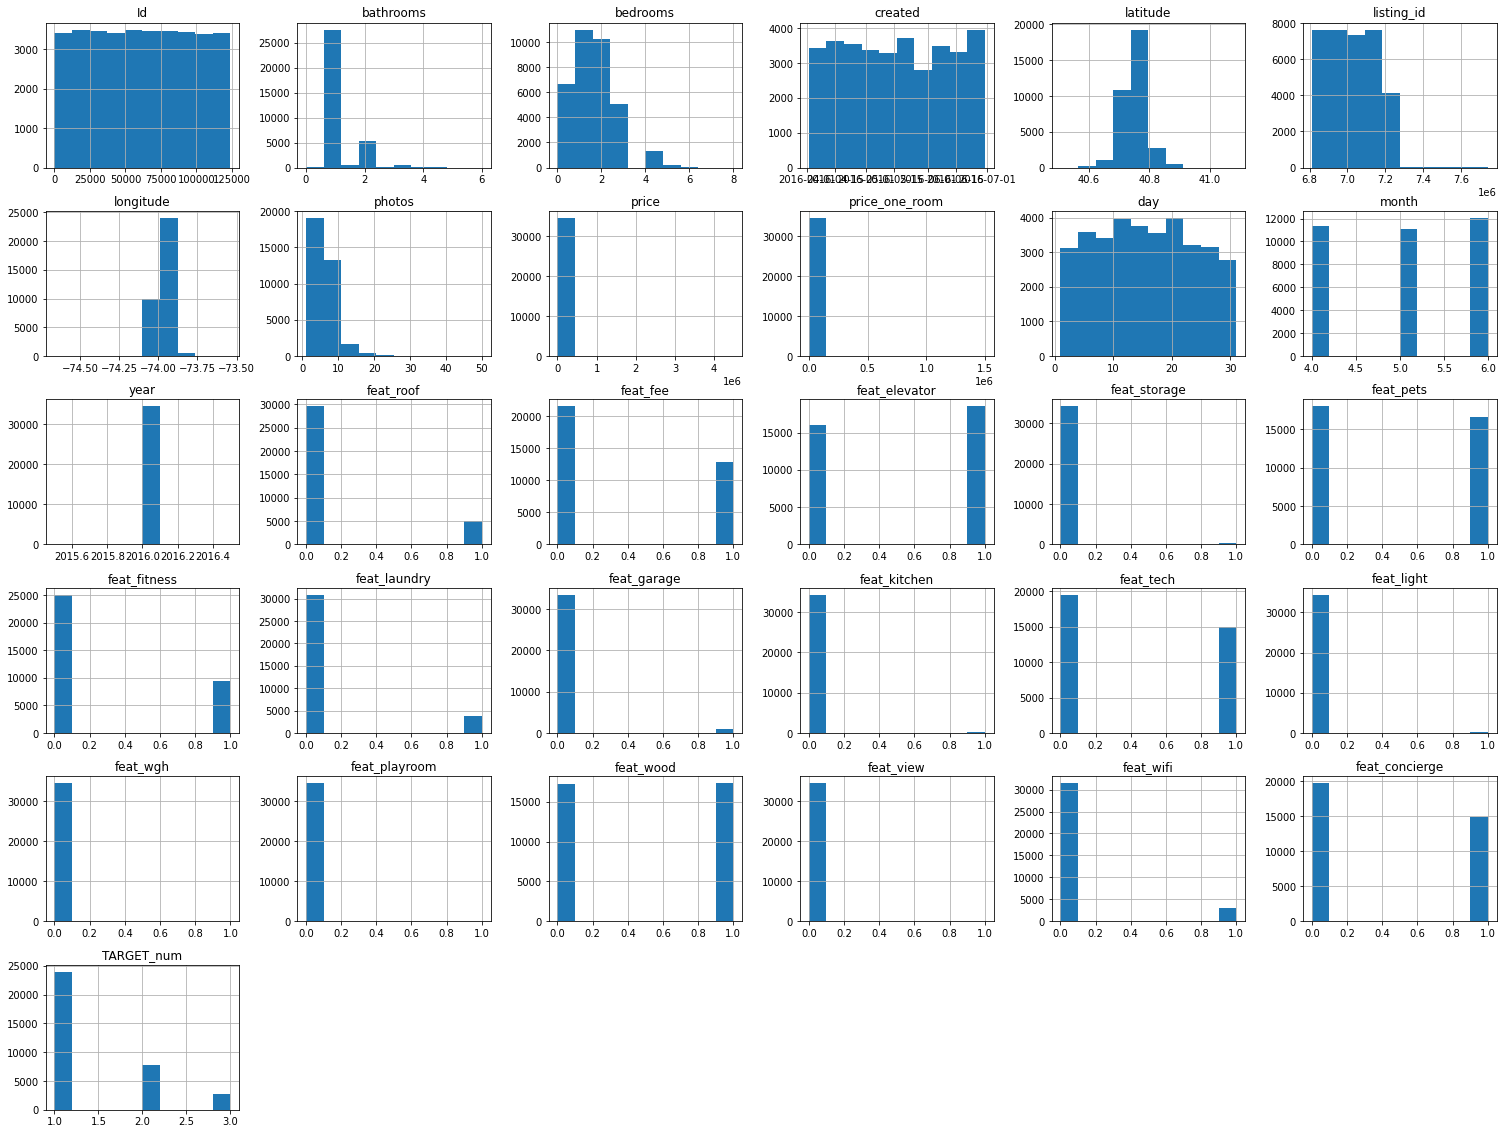

In [54]:
data_train_3.hist(figsize=(26,20))
None

Выводы по гистограммам:

1.   id - удалить из рассмотрения, т.к. нет повторяющихся значений - признак бесполезен.
1.   bathrooms - оставить, не будем логарифмировать, потому что хвотс не большой.
1.   bedrooms - оставить, не будем логарифмировать, потому что хвотс не большой.
1.   building_id - удалить из рассмотрения, т.к. строка - признак бесполезен.
1.   created - оставить, может есть влияние на популярность объявления. В test такой же временной промежуток, второй квартал 2016 года
1.   features - удалить из рассмотрения, т.к. строка - признак бесполезен.
1.   latitude - оставить, может есть влияние на популярность объявления. Нанести на карту точки Target разного цвета и посмотреть их расположение
1.   listing_id - удалить из рассмотрения, т.к. нет повторяющихся значений - признак бесполезен.
1.   longitude - оставить, может есть влияние на популярность объявления. Нанести на карту точки Target разного цвета и посмотреть их расположение 
1.   manager_id - удалить из рассмотрения, т.к. строка - признак бесполезен.
5.   photos - оставить, надо прологарифмировать
6.   price - посмотреть значения, кажется есть очень большие порядка $10^6$, возможно выбросы
6.   price_one_room - посмотреть значения, кажется есть очень большие порядка $10^6$, возможно выбросы
7.   day - оставить
8.   month - оставить
9.   year - удалить, для всеx объявлений один 2016 год, признак бесполезен.
10.   feat_roof - оставить.
11.   feat_fee - оставить.
12.   feat_elevator - оставить.
13.   feat_storage - удалить, только в 1 % объявлений признак = 1, остальные = 0, не информативно.
14.   feat_pets - оставить.
15.   feat_fitness - оставить.
16.   feat_laundry - оставить, в 10 % объявлений признак = 1, остальные = 0, посмотрим может пригодится.
17.   feat_garage - удалить, только в 3 % объявлений признак = 1, остальные = 0, не информативно.
18.   feat_kitchen - удалить, только в 1 % объявлений признак = 1, остальные = 0, не информативно.
19.   feat_tech - оставить.
20.   feat_light - удалить, только в 1 % объявлений признак = 1, остальные = 0, не информативно.
21.   feat_wgh - удалить, только в 1 % объявлений признак = 1, остальные = 0, не информативно.
22.   feat_playroom - удалить, только в 1 % объявлений признак = 1, остальные = 0, не информативно. 
23.   feat_wood - оставить.
24.   feat_view - удалить, только в 1 % объявлений признак = 1, остальные = 0, не информативно. 
25.   feat_wifi - оставить, в 10 % объявлений признак = 1, остальные = 0, посмотрим может пригодится.
26.   feat_concierge - оставить.

Собем в list_column_all все признаки, которые будем использовать для обучения

In [55]:
list_column_all = data_train_3.columns.tolist()
list_to_del = ['Id','building_id','features','listing_id','manager_id','year',\
               'feat_storage','feat_garage','feat_kitchen','feat_light', \
               'feat_wgh','feat_playroom','feat_view','created','TARGET_num']
for i in list_to_del:
  list_column_all.remove(i) 
list_column_all_test = copy.deepcopy(list_column_all)
list_column_all_test.append('Id')
list_column_all_test.remove('TARGET')
list_column_all

['bathrooms',
 'bedrooms',
 'latitude',
 'longitude',
 'photos',
 'price',
 'TARGET',
 'price_one_room',
 'day',
 'month',
 'feat_roof',
 'feat_fee',
 'feat_elevator',
 'feat_pets',
 'feat_fitness',
 'feat_laundry',
 'feat_tech',
 'feat_wood',
 'feat_wifi',
 'feat_concierge']

Посмотрим на карте точки Target разного цвета. Визуально они разбросаны одинаково. Нельзя сказать, что в каком-то районе более или менее популярные объявления. Синих точек много, потому что 70% из всех объявлений low.


In [56]:
fig = go.Figure(go.Scattermapbox(lat=data_train_3['latitude'], lon=data_train_3['longitude'],
                                 marker=dict(colorbar=dict(title="TARGET"),
                                             color=data_train_3['TARGET_num'])))
map_center =dict(lat=40.8, lon=-74)
fig.update_layout(mapbox_style="open-street-map", mapbox=dict(center=map_center, zoom=8))
fig.show()

Уберем объявления с ценой за комнату более 5_000. Их не много, около 55 штук, но они сильно выбиваются из среднего значения по всему признаку price_one_room.

In [57]:
df = data_train_3[data_train_3['price_one_room'] > 5000]
df.describe()

,Id,bathrooms,bedrooms,latitude,listing_id,longitude,photos,price,price_one_room,day,...,feat_kitchen,feat_tech,feat_light,feat_wgh,feat_playroom,feat_wood,feat_view,feat_wifi,feat_concierge,TARGET_num
count,55.000000,55.000000,55.000000,55.000000,5.500000e+01,55.000000,55.000000,5.500000e+01,5.500000e+01,55.000000,...,55.0,55.000000,55.0,55.0,55.0,55.000000,55.0,55.000000,55.000000,55.0
mean,61908.981818,1.118182,0.727273,40.746249,7.025443e+06,-73.985573,5.345455,1.584367e+05,6.310409e+04,16.436364,...,0.0,0.181818,0.0,0.0,0.0,0.309091,0.0,0.054545,0.454545,1.0
std,38936.594383,1.146507,1.433134,0.044624,1.306427e+05,0.023505,4.510146,6.445288e+05,2.256777e+05,8.118939,...,0.0,0.389249,0.0,0.0,0.0,0.466378,0.0,0.229184,0.502519,0.0
min,514.000000,0.000000,0.000000,40.613800,6.818903e+06,-74.020200,1.000000,5.250000e+03,5.250000e+03,1.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,1.0
25%,33616.000000,1.000000,0.000000,40.724350,6.901707e+06,-74.002650,1.000000,5.752000e+03,5.550000e+03,11.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,1.0
50%,55437.000000,1.000000,0.000000,40.738800,7.041970e+06,-73.991000,5.000000,8.333000e+03,6.995000e+03,15.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,1.0
75%,99021.000000,1.000000,1.000000,40.766500,7.146238e+06,-73.972200,7.500000,2.500000e+04,1.231875e+04,24.000000,...,0.0,0.000000,0.0,0.0,0.0,1.000000,0.0,0.000000,1.000000,1.0
max,123677.000000,6.000000,6.000000,40.865400,7.232177e+06,-73.920600,23.000000,4.490000e+06,1.496667e+06,30.000000,...,0.0,1.000000,0.0,0.0,0.0,1.000000,0.0,1.000000,1.000000,1.0


Вснесем изменения указанные выше, после гистограмм

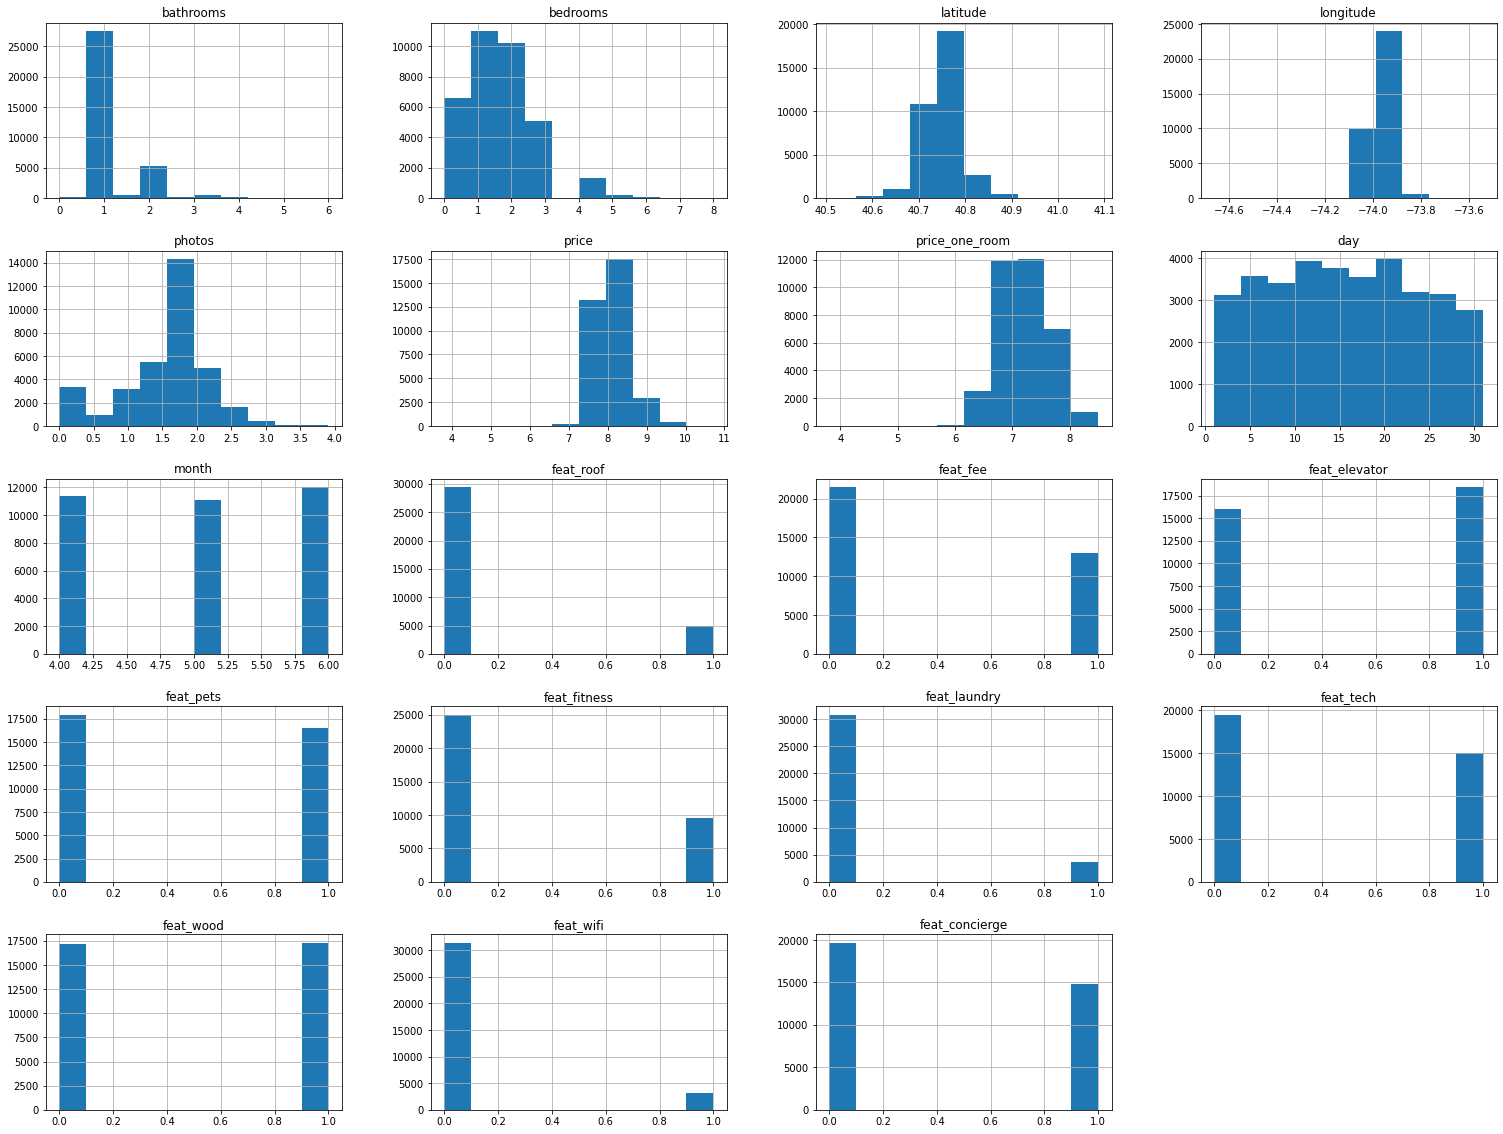

In [58]:
data_train_4 = data_train_3.copy(deep=True)
data_train_4 = data_train_4 [list_column_all]

data_train_4 = data_train_4[data_train_4['price_one_room'] < 5000]
#data_train_4['bathrooms']=np.log(np.maximum(0.1,data_train_4['bathrooms']))
#data_train_4['bedrooms']=np.log(np.maximum(0.1,data_train_4['bedrooms']))
data_train_4['photos']=np.log(data_train_4['photos'])
data_train_4['price']=np.log(data_train_4['price'])
data_train_4['price_one_room']=np.log(data_train_4['price_one_room'])

data_train_4.describe()
data_train_4.hist(figsize=(26,20))
None

Внесем аналогичные изменения в test: прологарифмируем и выберем нужные столбцы.

Еще добавим столбец Id. В нем лежат правильные ответы. Они нам пригодятся при расчете accuracy

In [59]:
data_test_4 = data_test_2.copy(deep=True)
data_test_4 = data_test_4[list_column_all_test]

data_test_4['photos']=np.log(data_test_4['photos'])
data_test_4['price']=np.log(data_test_4['price'])
data_test_4['price_one_room']=np.log(data_test_4['price_one_room'])

data_test_4.info()
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14806 entries, 0 to 14805
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bathrooms       14806 non-null  float64
 1   bedrooms        14806 non-null  int64  
 2   latitude        14806 non-null  float64
 3   longitude       14806 non-null  float64
 4   photos          14806 non-null  float64
 5   price           14806 non-null  float64
 6   price_one_room  14806 non-null  float64
 7   day             14795 non-null  float64
 8   month           14795 non-null  float64
 9   feat_roof       14806 non-null  int64  
 10  feat_fee        14806 non-null  int64  
 11  feat_elevator   14806 non-null  int64  
 12  feat_pets       14806 non-null  int64  
 13  feat_fitness    14806 non-null  int64  
 14  feat_laundry    14806 non-null  int64  
 15  feat_tech       14806 non-null  int64  
 16  feat_wood       14806 non-null  int64  
 17  feat_wifi       14806 non-null 

In [60]:
data_train_4.info()
None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34459 entries, 0 to 34545
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bathrooms       34459 non-null  float64
 1   bedrooms        34459 non-null  int64  
 2   latitude        34459 non-null  float64
 3   longitude       34459 non-null  float64
 4   photos          34459 non-null  float64
 5   price           34459 non-null  float64
 6   TARGET          34459 non-null  object 
 7   price_one_room  34459 non-null  float64
 8   day             34459 non-null  int64  
 9   month           34459 non-null  int64  
 10  feat_roof       34459 non-null  int64  
 11  feat_fee        34459 non-null  int64  
 12  feat_elevator   34459 non-null  int64  
 13  feat_pets       34459 non-null  int64  
 14  feat_fitness    34459 non-null  int64  
 15  feat_laundry    34459 non-null  int64  
 16  feat_tech       34459 non-null  int64  
 17  feat_wood       34459 non-null 

Теперь у нас в train и test одинаовое количство столбцов, которые одинаково подготовлены для обучения.

In [61]:
data_test_4.isna().sum()

bathrooms          0
bedrooms           0
latitude           0
longitude          0
photos             0
price              0
price_one_room     0
day               11
month             11
feat_roof          0
feat_fee           0
feat_elevator      0
feat_pets          0
feat_fitness       0
feat_laundry       0
feat_tech          0
feat_wood          0
feat_wifi          0
feat_concierge     0
Id                 0
dtype: int64

В data_test_4 получилось 11 Nan значений. Это очень мало из 14_000 объявлений, поэтому из можно удалить.

In [62]:
data_test_4.dropna(inplace=True)
data_test_4.isna().sum()

bathrooms         0
bedrooms          0
latitude          0
longitude         0
photos            0
price             0
price_one_room    0
day               0
month             0
feat_roof         0
feat_fee          0
feat_elevator     0
feat_pets         0
feat_fitness      0
feat_laundry      0
feat_tech         0
feat_wood         0
feat_wifi         0
feat_concierge    0
Id                0
dtype: int64

<a name="fit_predict"></a>
# 5. Обучаем модель и предсказываем класс

1.   Нормализуем данные в train и test.
2.   Рассмотрим три набора признаков:
*   числовые признаки, которые были в исходном наборе
*   добавим простые признаки, которые получились из исходных, например количество фотографий
*   добавим признаки, которые получились из столбца features
3.   Еще можно попробовать для каждого набора сравнить значения cross_val_score, чтобы убедиться в правильности выбора признаков .
4.   Подсказка учителя. Данные в train не сбалансированы (70% значейний low), поэтому веса class_weight={'low':0.33, 'high':2.9, 'medium':1.}

In [63]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import cross_val_score

list_column_all.remove('TARGET')

Нормализуем данные

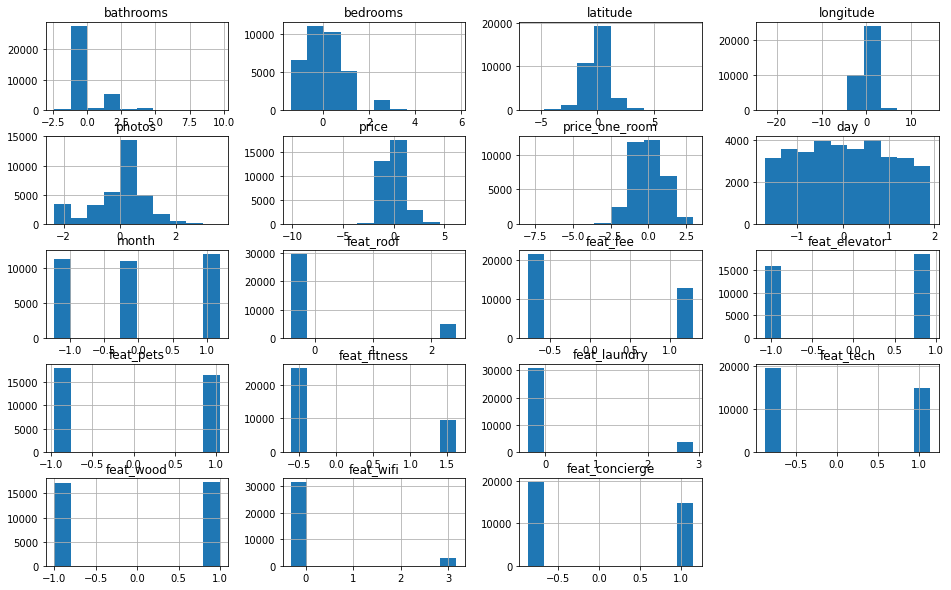

In [64]:
X_train = data_train_4[list_column_all]
y_train = data_train_4['TARGET']
X_test = data_test_4[list_column_all]
y_test = data_test_4['Id']

pca = StandardScaler()
pca.fit(X_train)
X_train=pca.transform(X_train)
X_test=pca.transform(X_test) # применяем к test нормировку с mu и sigma из train

# переписываем навания столбцов, которые потерялить после нормализации
X_train = pd.DataFrame(data = X_train, columns=list_column_all) 
X_test = pd.DataFrame(data = X_test, columns=list_column_all)  

X_train.hist(figsize=(16,10))
None

Посмотрим числовые признаки, которые были в исходном наборе.

In [65]:
list_1=['bathrooms','bedrooms','latitude','longitude','price']
X_train_1 = X_train[list_1]
X_test_1 = X_test[list_1]
lg = LogisticRegression(multi_class='ovr', solver='lbfgs',
                        class_weight={'low':0.33, 'high':2.9, 'medium':1.})
lg.fit(X_train_1, y_train)
y_pred_1 = lg.predict(X_test_1)
print('accuracy_score на признаках из 1 списка = ',accuracy_score(y_test,y_pred_1),'\n')

# Выбираем 5 лучших фичей с помощью скоринговой функции для классификации f_classif в методе ANOVA
x_data_kbest = SelectKBest(f_classif, k=5).fit_transform(X_train_1, y_train)

# Выбираем фичи по граничному значению дисперсии данных =0,9
x_data_varth = VarianceThreshold(.9).fit_transform(X_train_1)

# Результат для исходных данных
print('cross_val_score на исходных данных =',cross_val_score(
    LogisticRegression(), X_train_1, y_train, scoring='accuracy').mean())
# Для отбора по вариативности
print('cross_val_score для признаков с D>0.9 =',cross_val_score(
    LogisticRegression(), x_data_varth, y_train, scoring='accuracy').mean())
# Для отбора по ANOVA
print('cross_val_score на 5 признаках ANOVA =',cross_val_score(
    LogisticRegression(), x_data_kbest, y_train, scoring='accuracy').mean())

accuracy_score на признаках из 1 списка =  0.5541061169313958 

cross_val_score на исходных данных = 0.698308155186225
cross_val_score для признаков с D>0.9 = 0.698308155186225
cross_val_score на 5 признаках ANOVA = 0.698308155186225


Все три значения cross_val_score совпадают, значит в данном случае accuracy_score = 0.554.

Теперь добавим и имеющимся признакам простые признаки, которые получились из исходных, такие как, количество фотографий.

In [66]:
list_2=['bathrooms','bedrooms','latitude','longitude','photos','price','price_one_room','day','month']
X_train_2 = X_train[list_2]
X_test_2 = X_test[list_2]
lg = LogisticRegression(multi_class='ovr', solver='lbfgs',
                        class_weight={'low':0.33, 'high':2.9, 'medium':1.})
lg.fit(X_train_2, y_train)
y_pred_2 = lg.predict(X_test_2)
print('accuracy_score на признаках из 2 списка = ',accuracy_score(y_test,y_pred_2),'\n')

# Выбираем 5 лучших фичей с помощью скоринговой функции для классификации f_classif в методе ANOVA
x_data_kbest_5 = SelectKBest(f_classif, k=5).fit_transform(X_train_2, y_train)
x_data_kbest_7 = SelectKBest(f_classif, k=7).fit_transform(X_train_2, y_train)

# Выбираем фичи по граничному значению дисперсии данных =0,9
x_data_varth = VarianceThreshold(.9).fit_transform(X_train_2)

# Результат для исходных данных
print('cross_val_score на исходных данных =',cross_val_score(
    LogisticRegression(), X_train_2, y_train, scoring='accuracy').mean())
# Для отбора по вариативности
print('cross_val_score для признаков с D>0.9 =',cross_val_score(
    LogisticRegression(), x_data_varth, y_train, scoring='accuracy').mean())
# Для отбора по ANOVA
print('cross_val_score на 5 признаках ANOVA =',cross_val_score(
    LogisticRegression(), x_data_kbest_5, y_train, scoring='accuracy').mean())
print('cross_val_score на 7 признаках ANOVA =',cross_val_score(
    LogisticRegression(), x_data_kbest_7, y_train, scoring='accuracy').mean())

accuracy_score на признаках из 2 списка =  0.5661372085163907 

cross_val_score на исходных данных = 0.6947386857099013
cross_val_score для признаков с D>0.9 = 0.6947386857099013
cross_val_score на 5 признаках ANOVA = 0.6967701021957616
cross_val_score на 7 признаках ANOVA = 0.694390476934048


cross_val_score оказался чуть больше для 5 признаков, найденных ANOVA. Посмотрим accuracy на них.

In [67]:
# выбираем нужные 5 признаков
x_data_kbest_5 = SelectKBest(f_classif, k=5)
x_data_kbest_5.fit(X_train_2, y_train)
X_train_2=x_data_kbest_5.transform(X_train_2)
X_test_2=x_data_kbest_5.transform(X_test_2)

# смотрим для них accuracy
lg = LogisticRegression(multi_class='ovr', solver='lbfgs',
                        class_weight={'low':0.33, 'high':2.9, 'medium':1.})
lg.fit(X_train_2, y_train)
y_pred_2 = lg.predict(X_test_2)
print('accuracy_score на 5 признаках из 2 списка = ',accuracy_score(y_test,y_pred_2),'\n')


accuracy_score на 5 признаках из 2 списка =  0.5547820209530246 



accuracy_score на 5 признаках стал чуть ниже, чем для всех признаков из 2 списка, поэтому оставим accuracy_score = 0.566. Он чуть больше, чем для признаков из первого списка.

Теперь добавим к имеющимся признакам признаки, которые мы нашли в столбце feature.

In [68]:
list_3=list_column_all
X_train_3 = X_train[list_3]
X_test_3 = X_test[list_3]
lg = LogisticRegression(multi_class='ovr', solver='lbfgs',
                        class_weight={'low':0.33, 'high':2.9, 'medium':1.})
lg.fit(X_train_3, y_train)
y_pred_3 = lg.predict(X_test_3)
print('accuracy_score на признаках из 3 списка = ',accuracy_score(y_test,y_pred_3),'\n')

# Выбираем 5 лучших фичей с помощью скоринговой функции для классификации f_classif в методе ANOVA
x_data_kbest_5 = SelectKBest(f_classif, k=5).fit_transform(X_train_3, y_train)
x_data_kbest_7 = SelectKBest(f_classif, k=7).fit_transform(X_train_3, y_train)

# Выбираем фичи по граничному значению дисперсии данных =0,9
x_data_varth = VarianceThreshold(.9).fit_transform(X_train_3)

# Результат для исходных данных
print('cross_val_score на исходных данных =',cross_val_score(
    LogisticRegression(), X_train_3, y_train, scoring='accuracy').mean())
# Для отбора по вариативности
print('cross_val_score для признаков с D>0.9 =',cross_val_score(
    LogisticRegression(), x_data_varth, y_train, scoring='accuracy').mean())
# Для отбора по ANOVA
print('cross_val_score на 5 признаках ANOVA =',cross_val_score(
    LogisticRegression(), x_data_kbest_5, y_train, scoring='accuracy').mean())
print('cross_val_score на 7 признаках ANOVA =',cross_val_score(
    LogisticRegression(), x_data_kbest_7, y_train, scoring='accuracy').mean())

accuracy_score на признаках из 3 списка =  0.5904021628928692 

cross_val_score на исходных данных = 0.6978148885476722
cross_val_score для признаков с D>0.9 = 0.6978148885476722
cross_val_score на 5 признаках ANOVA = 0.6937521313769598
cross_val_score на 7 признаках ANOVA = 0.6971184836294667


cross_val_score оказался лучший на исходных данных поэтому оставим accuracy_score = 0.5904. 

**Вывод**: лучший accuracy_score = 0.5904. Надо еще внимательнее посмотреть столбец feature, может найдутся полезные признаки.

Сохраним результат в csv-файл.

In [70]:
submit = pd.DataFrame.from_dict({'Id_test':data_test_4.Id.values, 'TARGET': y_pred_3})
submit['ID'] = np.arange(len(submit))
submit[['ID','TARGET','Id_test']].to_csv("sumbit.csv", index=False)
submit[['ID','TARGET','Id_test']].head()

,ID,TARGET,Id_test
0,0,medium,low
1,1,high,low
2,2,high,low
3,3,medium,high
4,4,medium,medium
